In [9]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.frequent_patterns import fpgrowth
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Load the dataset
file_path = 'crop_yield.csv/crop_yield.csv'
data = pd.read_csv(file_path)
data.head()

# Save the preprocessed dataset



,Region,Soil_Type,Crop,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Weather_Condition,Days_to_Harvest,Yield_tons_per_hectare
0,West,Sandy,Cotton,897.077239,27.676966,False,True,Cloudy,122,6.555816
1,South,Clay,Rice,992.673282,18.026142,True,True,Rainy,140,8.527341
2,North,Loam,Barley,147.998025,29.794042,False,False,Sunny,106,1.127443
3,North,Sandy,Soybean,986.866331,16.644190,False,True,Rainy,146,6.517573
4,South,Silt,Wheat,730.379174,31.620687,True,True,Cloudy,110,7.248251


In [10]:
# Display the first few rows for inspection
print("Initial Data:")
print(data.info())



Initial Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   Region                  1000000 non-null  object 
 1   Soil_Type               1000000 non-null  object 
 2   Crop                    1000000 non-null  object 
 3   Rainfall_mm             1000000 non-null  float64
 4   Temperature_Celsius     1000000 non-null  float64
 5   Fertilizer_Used         1000000 non-null  bool   
 6   Irrigation_Used         1000000 non-null  bool   
 7   Weather_Condition       1000000 non-null  object 
 8   Days_to_Harvest         1000000 non-null  int64  
 9   Yield_tons_per_hectare  1000000 non-null  float64
dtypes: bool(2), float64(3), int64(1), object(4)
memory usage: 62.9+ MB
None


In [11]:
print(data.dtypes)


Region                     object
Soil_Type                  object
Crop                       object
Rainfall_mm               float64
Temperature_Celsius       float64
Fertilizer_Used              bool
Irrigation_Used              bool
Weather_Condition          object
Days_to_Harvest             int64
Yield_tons_per_hectare    float64
dtype: object


In [12]:
data.drop(columns=['Days_to_Harvest'], inplace=True)


In [13]:
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
print(numeric_cols)




Index(['Rainfall_mm', 'Temperature_Celsius', 'Yield_tons_per_hectare'], dtype='object')


In [14]:
categorical_cols = data.select_dtypes(include=['object']).columns
print(categorical_cols)

Index(['Region', 'Soil_Type', 'Crop', 'Weather_Condition'], dtype='object')


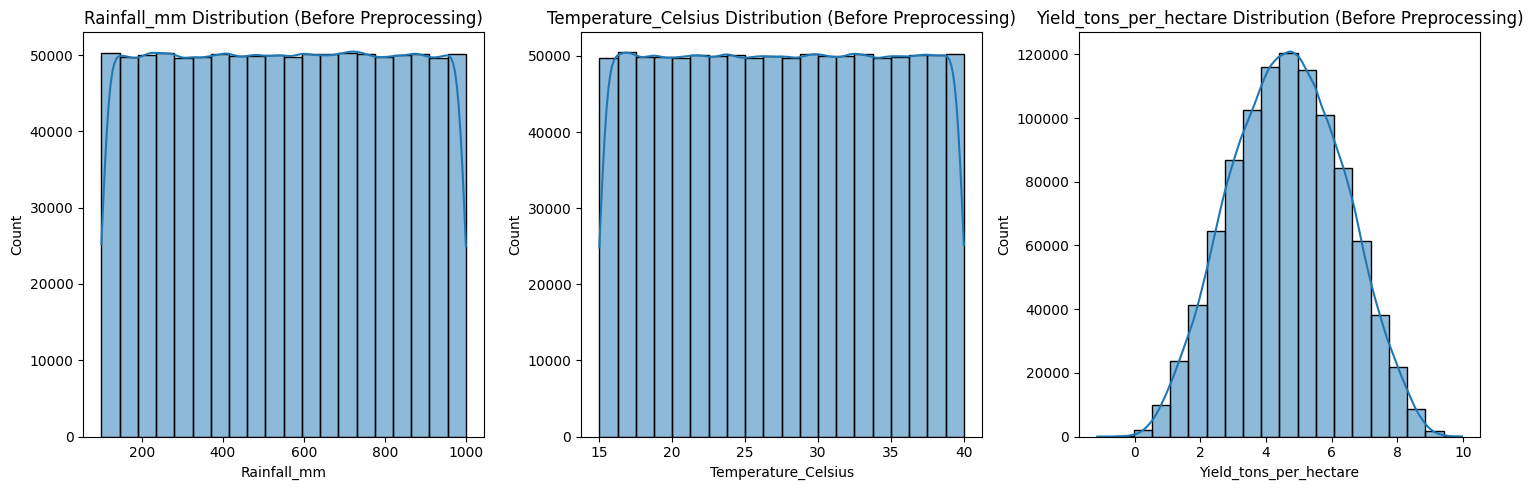

In [15]:
# Plot numeric columns
num_numeric_cols = len(numeric_cols)
rows_numeric = math.ceil(num_numeric_cols / 3)

fig, axes = plt.subplots(rows_numeric, 3, figsize=(15, rows_numeric * 5))
axes = axes.flatten()  # Flatten to easily iterate over axes
for i, col in enumerate(numeric_cols):
    sns.histplot(data[col], bins=20, kde=True, ax=axes[i])
    axes[i].set_title(f'{col} Distribution (Before Preprocessing)')
# Hide unused subplots
for j in range(len(numeric_cols), len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()




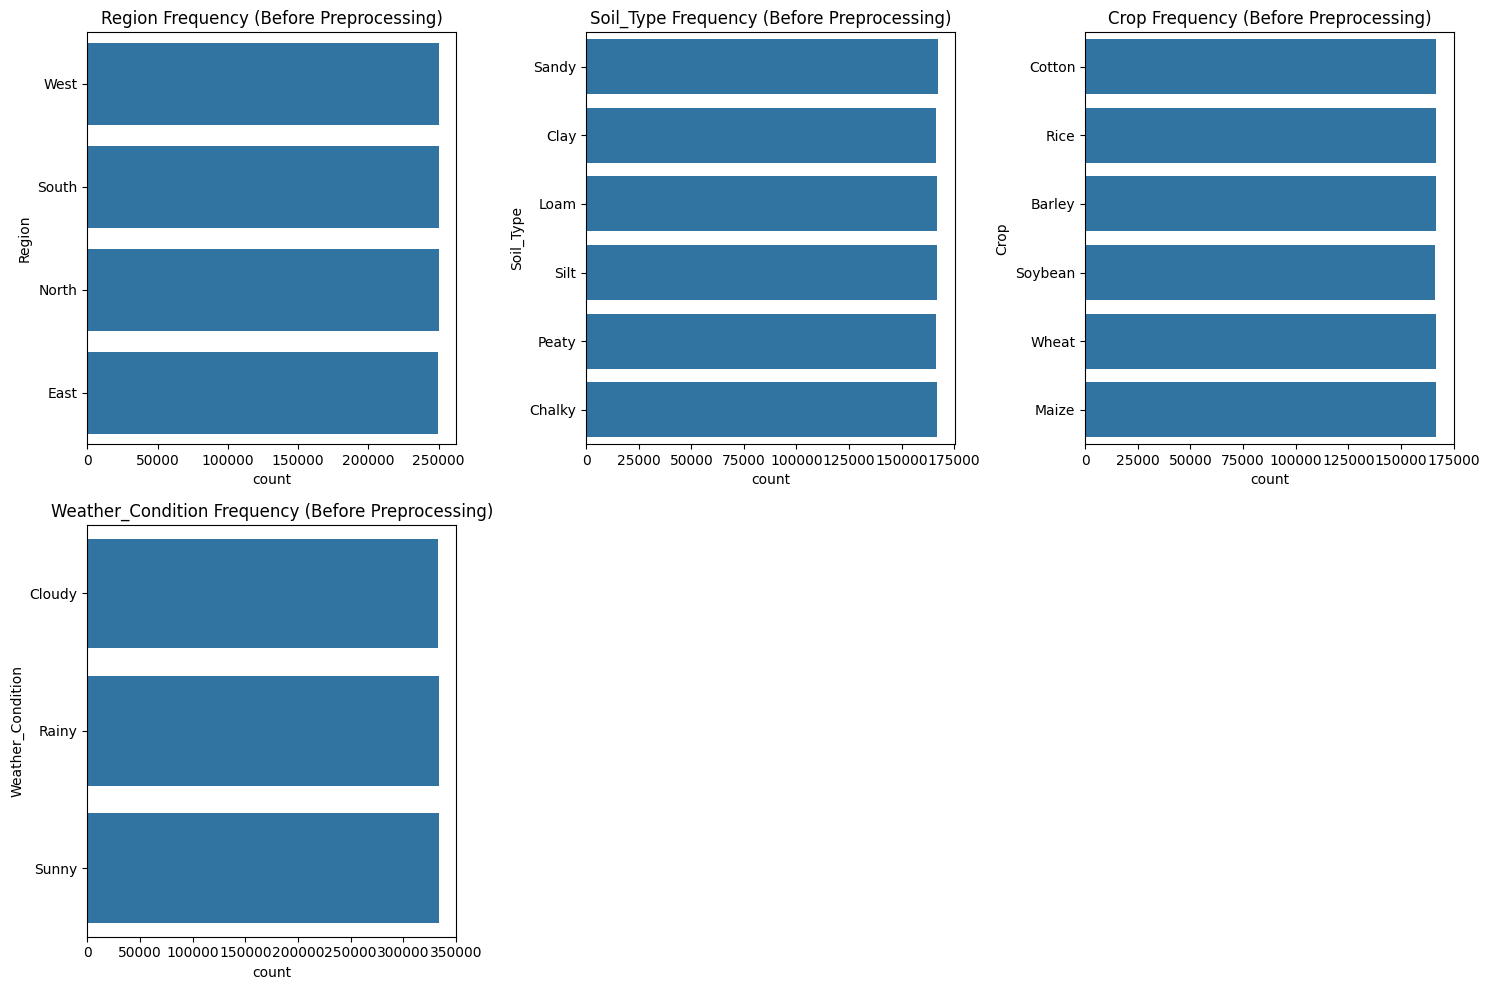

In [16]:
# Plot categorical columns
num_categorical_cols = len(categorical_cols)
rows_categorical = math.ceil(num_categorical_cols / 3)

fig, axes = plt.subplots(rows_categorical, 3, figsize=(15, rows_categorical * 5))
axes = axes.flatten()  # Flatten to easily iterate over axes
for i, col in enumerate(categorical_cols):
    sns.countplot(data=data, y=col, ax=axes[i])
    axes[i].set_title(f'{col} Frequency (Before Preprocessing)')
# Hide unused subplots
for j in range(len(categorical_cols), len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()

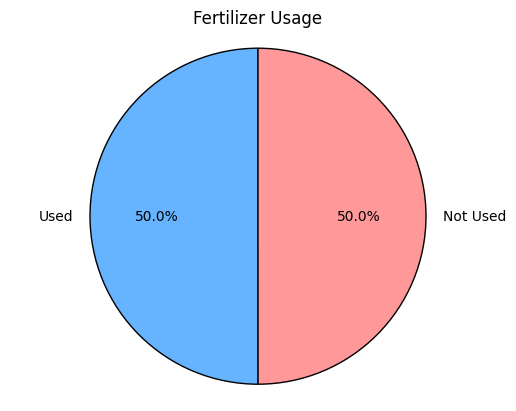

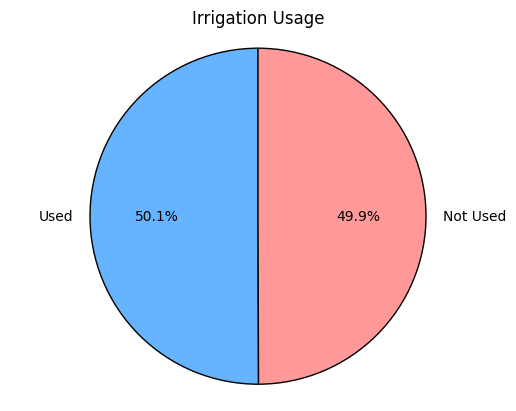

In [17]:
# Create a function to plot pie charts
def plot_pie(data, title):
    value_counts = data.value_counts()
    labels = ['Used', 'Not Used']
    sizes = value_counts.values
    colors = ['#66b3ff', '#ff9999']

    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
    plt.title(title)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

# Plot Fertilizer Used Pie Chart
plot_pie(data['Fertilizer_Used'], 'Fertilizer Usage')

# Plot Irrigation Used Pie Chart
plot_pie(data['Irrigation_Used'], 'Irrigation Usage')

In [18]:
# Binning numerical columns for association rule mining
data['Rainfall_Category'] = pd.cut(data['Rainfall_mm'], bins=[0, 100, 200, 300, 1000], labels=['Low', 'Medium', 'High', 'Very High'])
data['Temperature_Category'] = pd.cut(data['Temperature_Celsius'], bins=[-10, 10, 20, 30, 50], labels=['Cold', 'Mild', 'Warm', 'Hot'])
data['Yield_Category'] = pd.cut(data['Yield_tons_per_hectare'], bins=[0, 1, 3, 5, 10], labels=['Low', 'Medium', 'High', 'Very High'])


In [19]:
# Drop original numerical columns
data.drop(columns=['Rainfall_mm', 'Temperature_Celsius', 'Yield_tons_per_hectare'], inplace=True)

In [22]:
# Encode categorical variables for association rule mining
encoded_df = pd.get_dummies(data)


encoded_df['Irrigation_Not_Used'] = ~encoded_df['Irrigation_Used']

# Add 'Fertilizer_Not_Used' as the opposite of 'Fertilizer_Used'
encoded_df['Fertilizer_Not_Used'] = ~encoded_df['Fertilizer_Used']

# Convert to transactional format for algorithms
print("Encoded Data:")
print(encoded_df.head())

Encoded Data:
   Fertilizer_Used  Irrigation_Used  Region_East  Region_North  Region_South  \
0            False             True        False         False         False   
1             True             True        False         False          True   
2            False            False        False          True         False   
3            False             True        False          True         False   
4             True             True        False         False          True   

   Region_West  Soil_Type_Chalky  Soil_Type_Clay  Soil_Type_Loam  \
0         True             False           False           False   
1        False             False            True           False   
2        False             False           False            True   
3        False             False           False           False   
4        False             False           False           False   

   Soil_Type_Peaty  ...  Temperature_Category_Cold  Temperature_Category_Mild  \
0            Fa

In [23]:
encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 35 columns):
 #   Column                       Non-Null Count    Dtype
---  ------                       --------------    -----
 0   Fertilizer_Used              1000000 non-null  bool 
 1   Irrigation_Used              1000000 non-null  bool 
 2   Region_East                  1000000 non-null  bool 
 3   Region_North                 1000000 non-null  bool 
 4   Region_South                 1000000 non-null  bool 
 5   Region_West                  1000000 non-null  bool 
 6   Soil_Type_Chalky             1000000 non-null  bool 
 7   Soil_Type_Clay               1000000 non-null  bool 
 8   Soil_Type_Loam               1000000 non-null  bool 
 9   Soil_Type_Peaty              1000000 non-null  bool 
 10  Soil_Type_Sandy              1000000 non-null  bool 
 11  Soil_Type_Silt               1000000 non-null  bool 
 12  Crop_Barley                  1000000 non-null  bool 
 13  Crop_Cotton  

In [20]:
encoded_df['Fertilizer_Not_Used']

NameError: name 'encoded_df' is not defined

# APPRIORI

In [24]:
from mlxtend.frequent_patterns import apriori, association_rules
frequent_itemsets = apriori(encoded_df, min_support=0.05, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.499940,(Fertilizer_Used)
1,0.499491,(Irrigation_Used)
2,0.249699,(Region_East)
3,0.250173,(Region_North)
4,0.250054,(Region_South)
...,...,...
750,0.057859,"(Fertilizer_Used, Irrigation_Used, Rainfall_Ca..."
751,0.058425,"(Fertilizer_Used, Irrigation_Used, Rainfall_Ca..."
752,0.058280,"(Fertilizer_Used, Irrigation_Used, Rainfall_Ca..."
753,0.069097,"(Fertilizer_Used, Irrigation_Used, Temperature..."


In [25]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1 , num_itemsets=len(frequent_itemsets))

In [26]:
# Sort the DataFrame by a specific column, for example, 'lift' or 'confidence' in ascending order
sorted_rules = rules.sort_values(by='lift', ascending=False)
# Print the top 10 association rules
print("Top 10 Association Rules:")
print(sorted_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

# Print the shape of the DataFrame
print("Shape of the rules DataFrame:", sorted_rules.shape)


Top 10 Association Rules:
                                            antecedents  \
2348         (Irrigation_Not_Used, Fertilizer_Not_Used)   
2349  (Yield_Category_Medium, Rainfall_Category_Very...   
251                             (Yield_Category_Medium)   
250                          (Rainfall_Category_Medium)   
1430                            (Yield_Category_Medium)   
1427         (Irrigation_Not_Used, Fertilizer_Not_Used)   
2485  (Fertilizer_Used, Irrigation_Used, Rainfall_Ca...   
2512                         (Yield_Category_Very High)   
2461  (Fertilizer_Used, Irrigation_Used, Rainfall_Ca...   
2478  (Temperature_Category_Warm, Yield_Category_Ver...   

                                            consequents   support  confidence  \
2348  (Yield_Category_Medium, Rainfall_Category_Very...  0.052975    0.211340   
2349         (Irrigation_Not_Used, Fertilizer_Not_Used)  0.052975    0.868386   
251                          (Rainfall_Category_Medium)  0.061085    0.359459   


In [27]:
rules.to_csv("association_rules.csv", index=False)

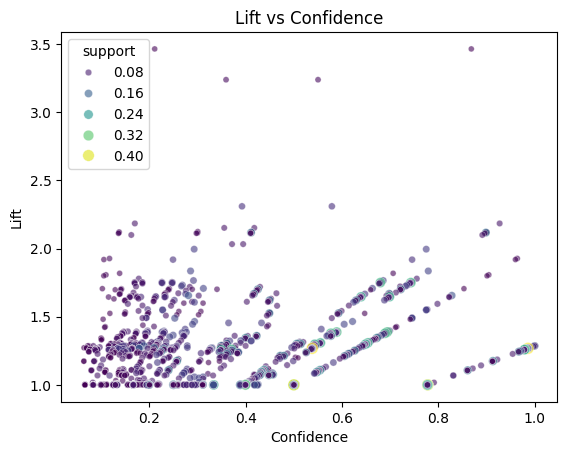

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(x=sorted_rules['confidence'], y=sorted_rules['lift'], size=sorted_rules['support'], alpha=0.6, hue=sorted_rules['support'], palette='viridis')
plt.title('Lift vs Confidence')
plt.xlabel('Confidence')
plt.ylabel('Lift')
plt.show()


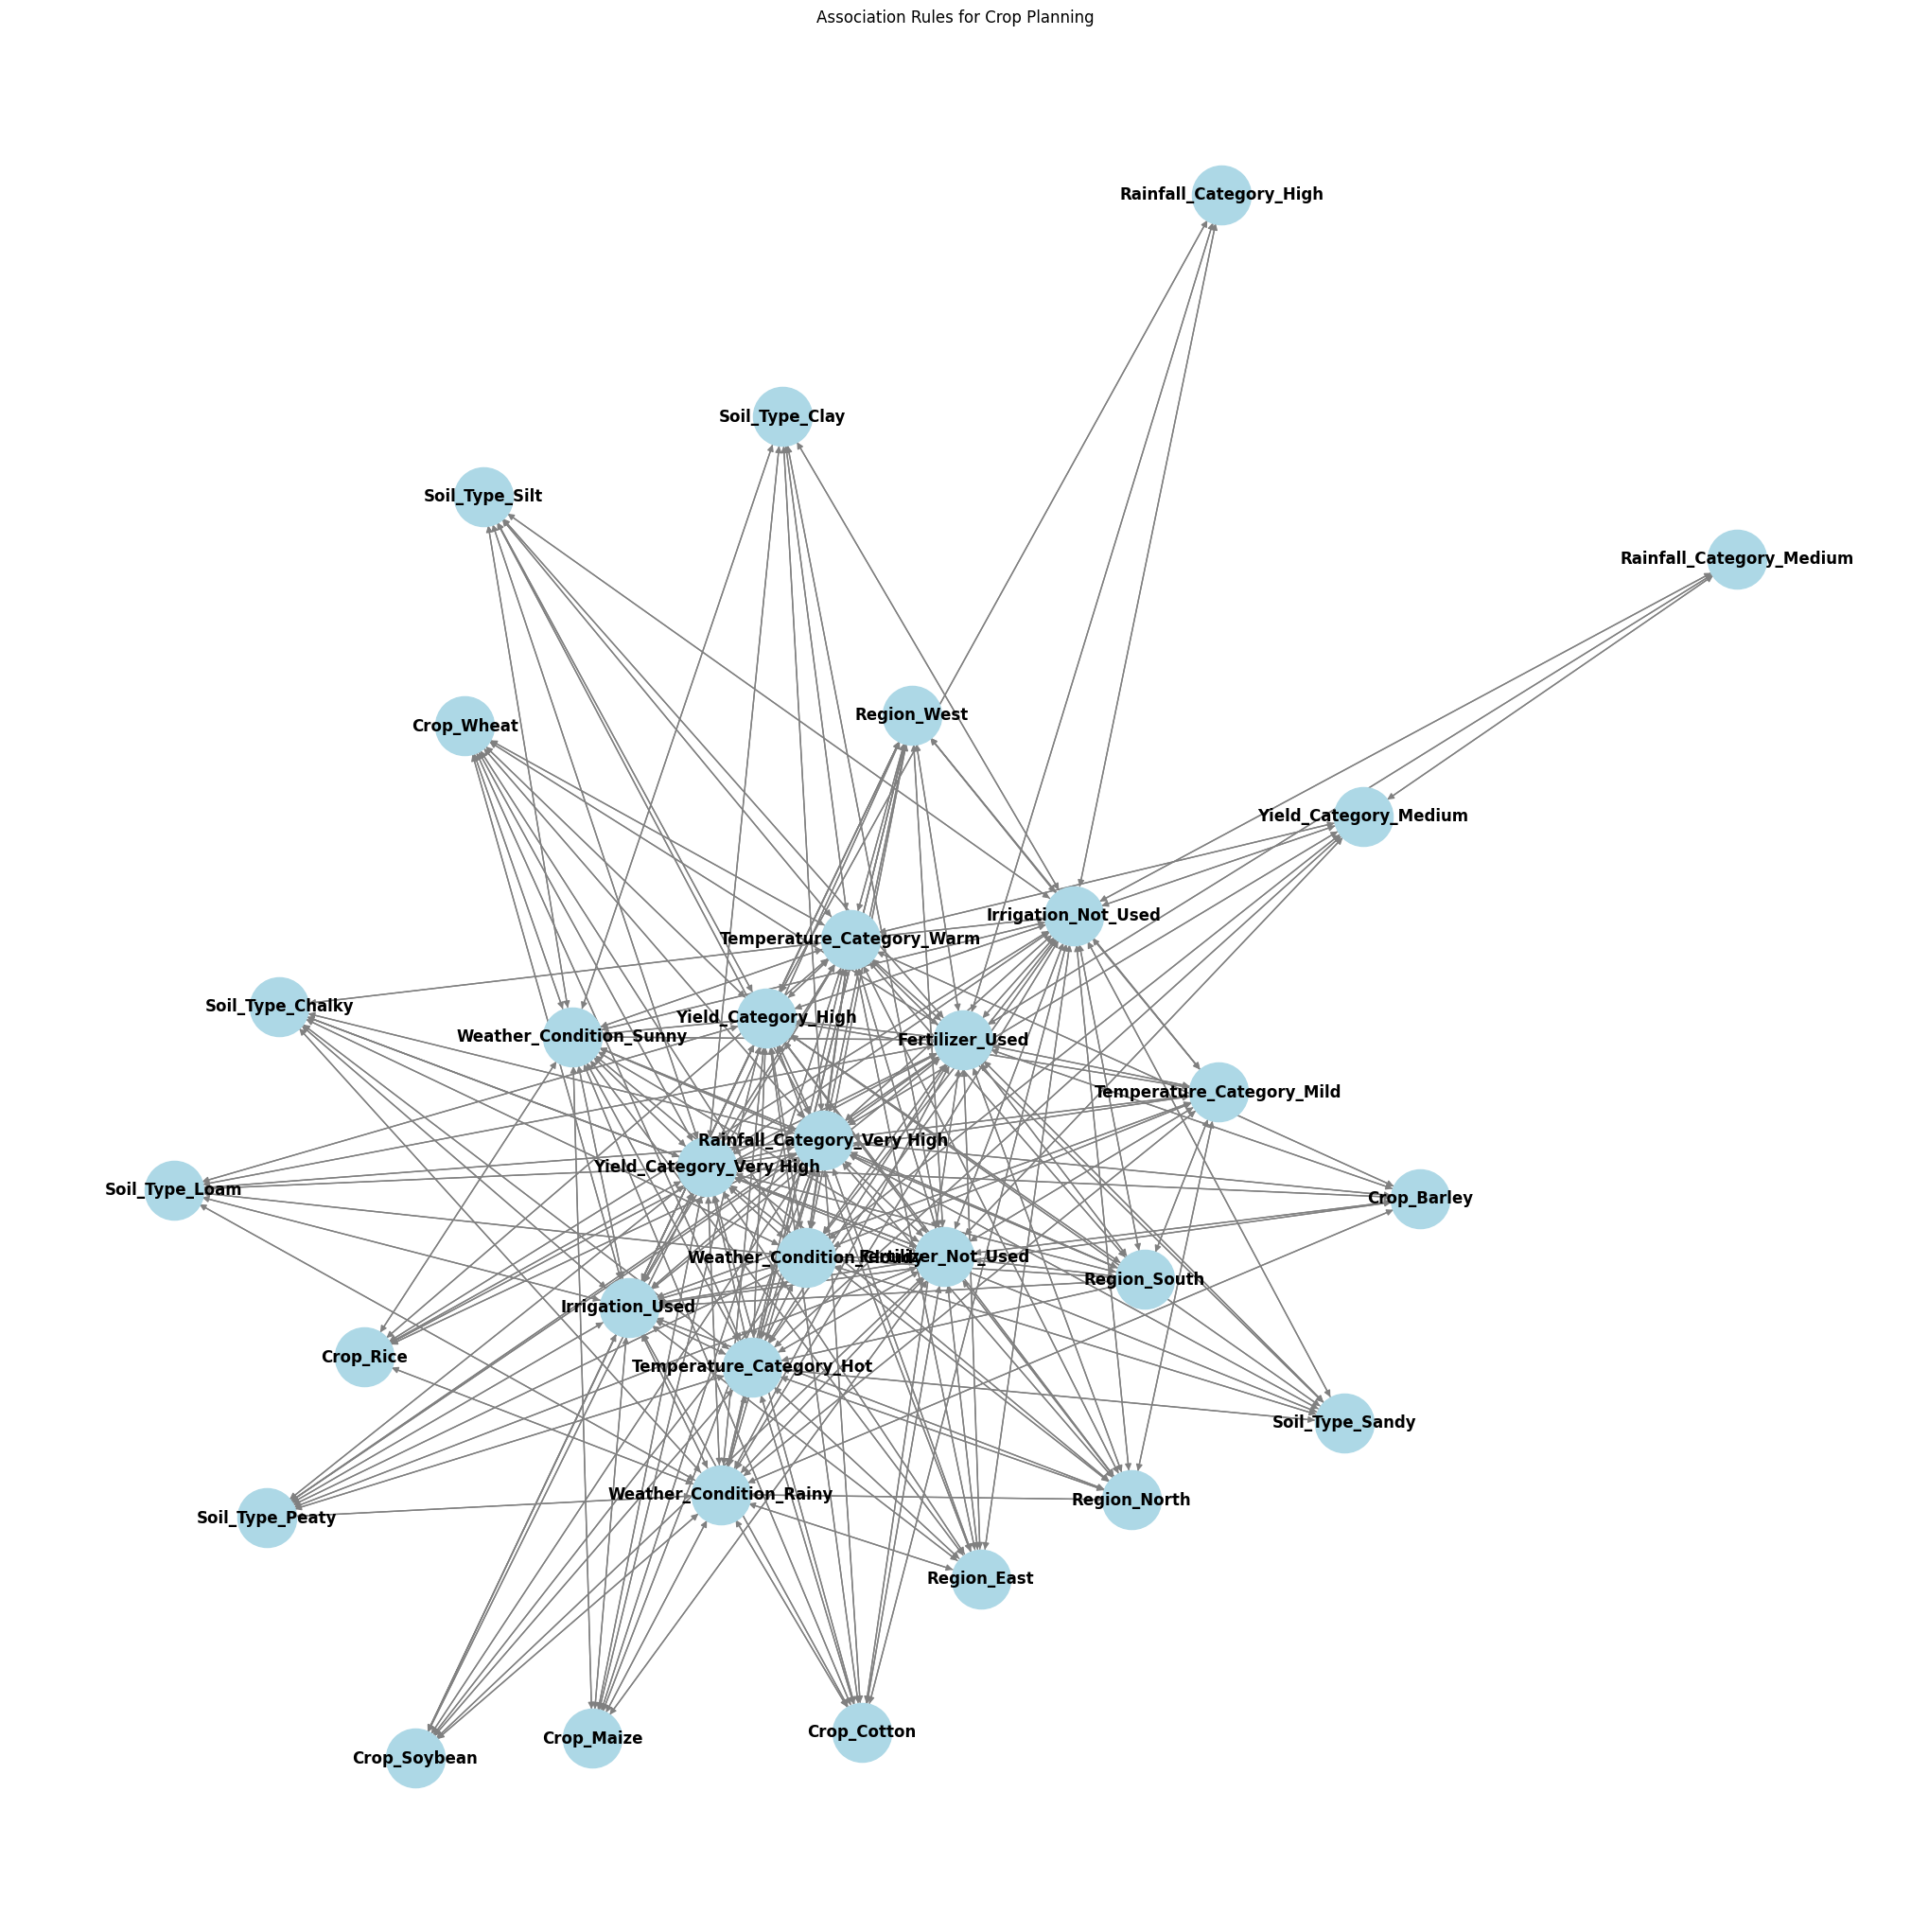

In [29]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a graph from the association rules
G = nx.DiGraph()

for index, row in rules.iterrows():
    for antecedent in row['antecedents']:
        for consequent in row['consequents']:
            G.add_edge(antecedent, consequent, weight=row['lift'])

# Plot the graph
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G, k=0.5, iterations=20)
nx.draw(G, pos, with_labels=True, font_weight='bold', node_color='lightblue', edge_color='gray', node_size=2000)
plt.title('Association Rules for Crop Planning')
plt.show()

C:\Users\exeed\AppData\Local\Temp\ipykernel_10952\367301988.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_rules['lift'].round(4), y=top_rules.index, palette='viridis')


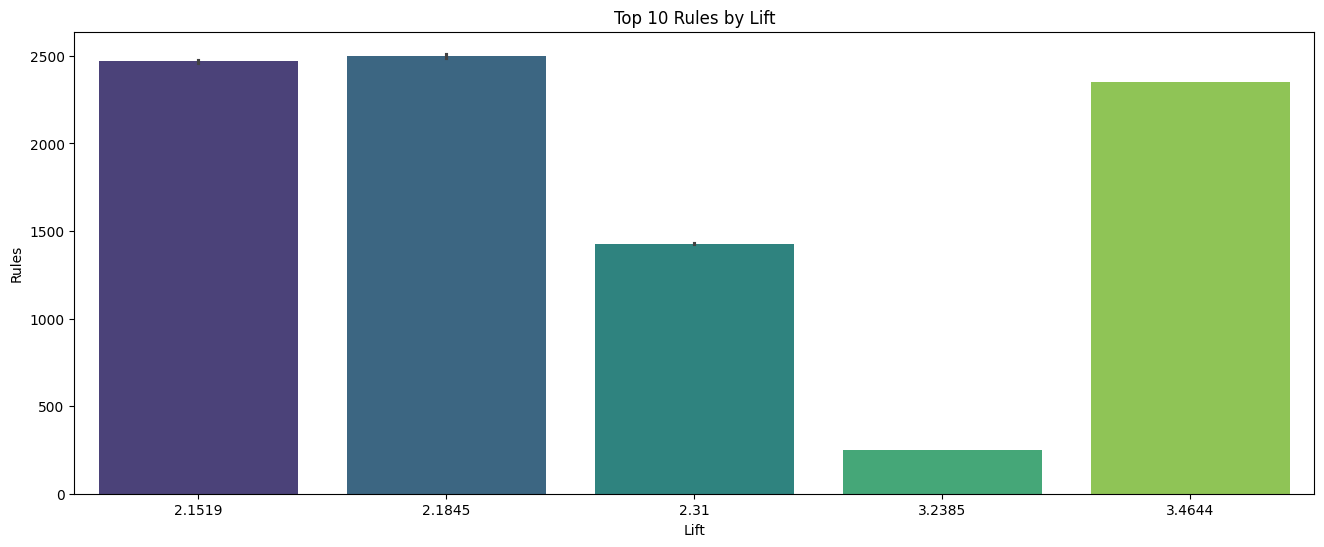

In [30]:
# Bar plot of top 10 rules by lift
top_rules = sorted_rules.nlargest(10, 'lift')
plt.figure(figsize=(16, 6))
sns.barplot(x=top_rules['lift'].round(4), y=top_rules.index, palette='viridis')
plt.title('Top 10 Rules by Lift')
plt.xlabel('Lift')
plt.ylabel('Rules')
plt.show()


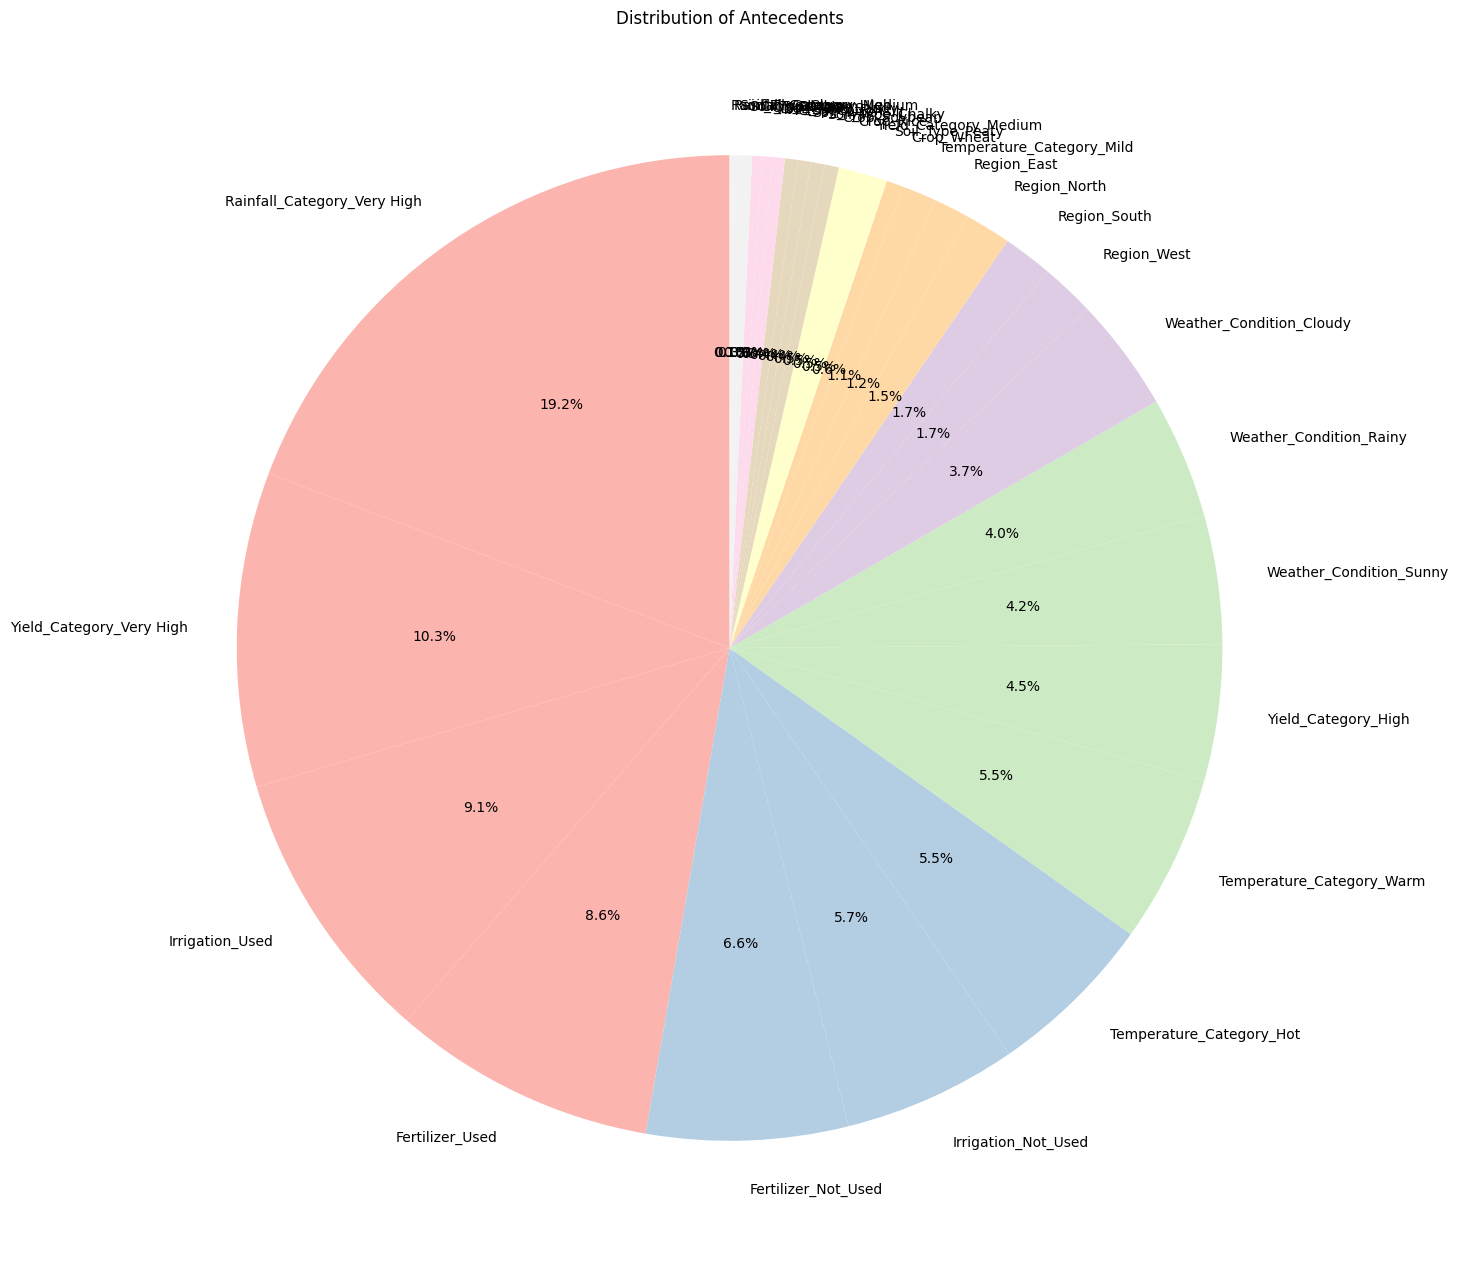

In [31]:
# Pie chart of antecedents frequency
antecedents_flat = [item for sublist in sorted_rules['antecedents'] for item in sublist]
antecedents_counts = pd.Series(antecedents_flat).value_counts()

plt.figure(figsize=(16, 16))
antecedents_counts.plot.pie(autopct='%1.1f%%', startangle=90, cmap='Pastel1')
plt.title('Distribution of Antecedents')
plt.ylabel('')
plt.show()



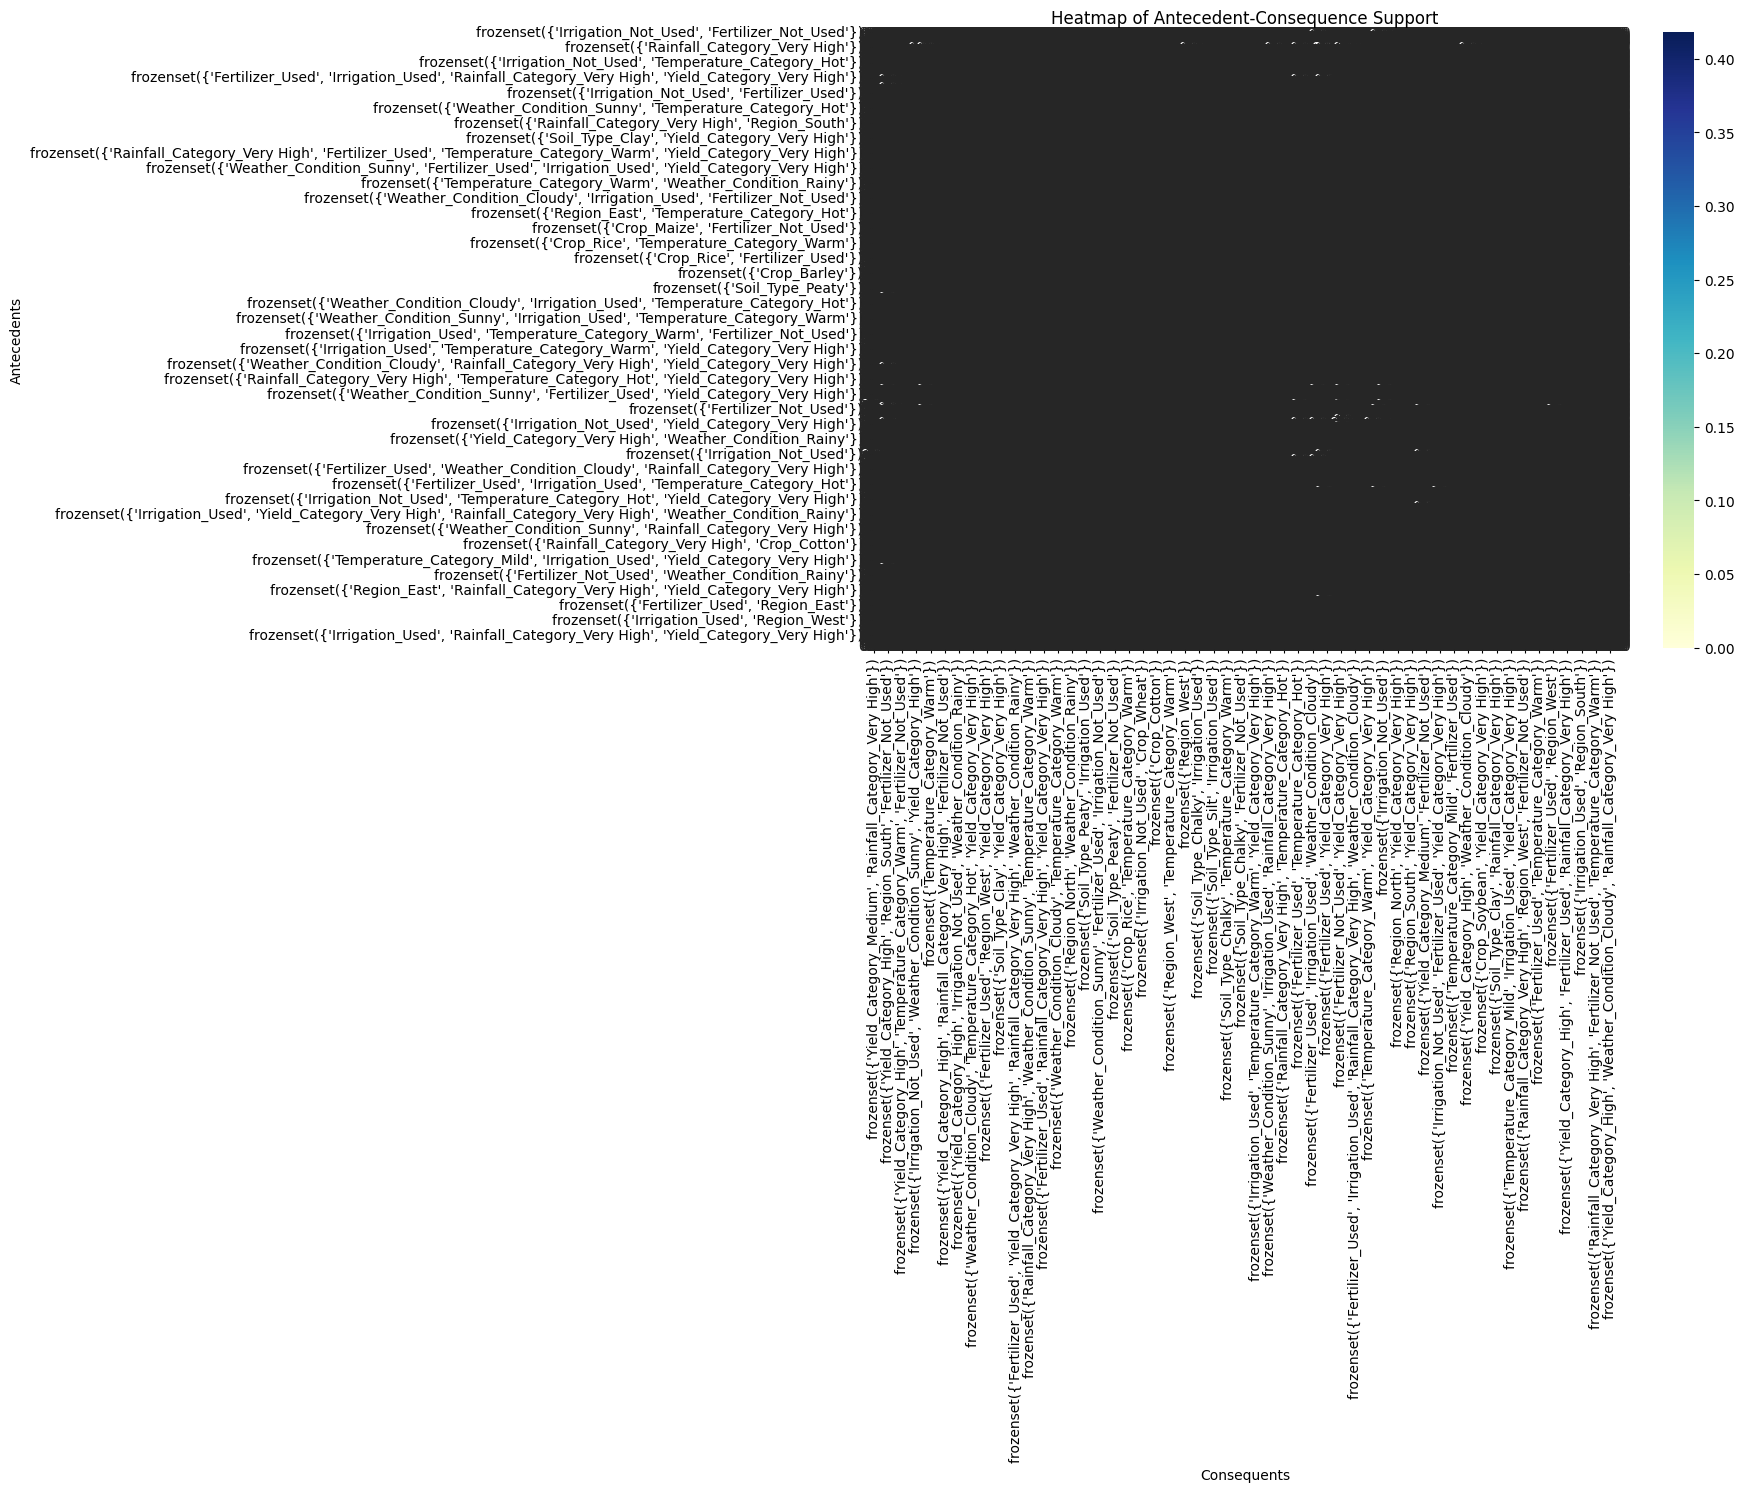

In [32]:
# Create a pivot table of antecedents vs consequents with support as values
import pandas as pd
heatmap_data = sorted_rules.pivot_table(index='antecedents', columns='consequents', values='support', fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt=".2f")
plt.title('Heatmap of Antecedent-Consequence Support')
plt.xlabel('Consequents')
plt.ylabel('Antecedents')
plt.show()


# fpgrowth

In [33]:
from mlxtend.frequent_patterns import fpgrowth, association_rules

# Generate frequent itemsets using FP-Growth
frequent_itemsets = fpgrowth(encoded_df, min_support=0.05, use_colnames=True)

# Display the frequent itemsets
print("Frequent Itemsets:")
print(frequent_itemsets)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1,num_itemsets=len(frequent_itemsets))


# Sort the rules by 'lift' in descending order
sorted_rules = sorted_rules.sort_values(by='lift', ascending=False)

# Print the top 10 association rules
print("Top 10 Association Rules:")
print(sorted_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

# Print the shape of the sorted DataFrame
print("Shape of the rules DataFrame:", sorted_rules.shape)
sorted_rules.to_csv("association_rules_filteringfp.csv", index=False)

Frequent Itemsets:
      support                                       itemsets
0    0.777353                  (Rainfall_Category_Very High)
1    0.500060                          (Fertilizer_Not_Used)
2    0.499491                              (Irrigation_Used)
3    0.424435                     (Yield_Category_Very High)
4    0.399517                    (Temperature_Category_Warm)
..        ...                                            ...
750  0.056069  (Irrigation_Not_Used, Rainfall_Category_High)
751  0.055751  (Rainfall_Category_High, Fertilizer_Not_Used)
752  0.055583      (Irrigation_Used, Rainfall_Category_High)
753  0.056774  (Yield_Category_High, Rainfall_Category_High)
754  0.055901      (Fertilizer_Used, Rainfall_Category_High)

[755 rows x 2 columns]
Top 10 Association Rules:
                                            antecedents  \
2348         (Irrigation_Not_Used, Fertilizer_Not_Used)   
2349  (Yield_Category_Medium, Rainfall_Category_Very...   
251                   

In [39]:
import pandas as pd

# Load the CSV file
csv_file = './association_rules.csv'  # Replace with your CSV file path
data = pd.read_csv(csv_file)

# Save the DataFrame as a pickle file
pickle_file = 'rulesapp.pkl'  # Replace with your desired pickle file path
data.to_pickle(pickle_file)

print(f"Data has been saved to {pickle_file}")


Data has been saved to rulesapp.pkl


In [40]:
import pandas as pd

# Load the CSV file
csv_file =  './association_rules_filteringfp.csv'  # Replace with your CSV file path
data = pd.read_csv(csv_file)

# Save the DataFrame as a pickle file
pickle_file = 'rulesfp.pkl'  # Replace with your desired pickle file path
data.to_pickle(pickle_file)

print(f"Data has been saved to {pickle_file}")


Data has been saved to rulesfp.pkl


In [41]:
data_loaded = pd.read_pickle(pickle_file)
print(data_loaded.head())


                                         antecedents  \
0  frozenset({'Irrigation_Not_Used', 'Fertilizer_...   
1  frozenset({'Yield_Category_Medium', 'Rainfall_...   
2               frozenset({'Yield_Category_Medium'})   
3            frozenset({'Rainfall_Category_Medium'})   
4  frozenset({'Irrigation_Not_Used', 'Fertilizer_...   

                                         consequents  antecedent support  \
0  frozenset({'Yield_Category_Medium', 'Rainfall_...            0.250662   
1  frozenset({'Irrigation_Not_Used', 'Fertilizer_...            0.061004   
2            frozenset({'Rainfall_Category_Medium'})            0.169936   
3               frozenset({'Yield_Category_Medium'})            0.110995   
4               frozenset({'Yield_Category_Medium'})            0.250662   

   consequent support   support  confidence      lift  representativity  \
0            0.061004  0.052975    0.211340  3.464369               1.0   
1            0.250662  0.052975    0.868386  3.464369   

In [ ]:
df = pd.read_pickle("./ml mini prijet/rulesapp.pkl")

filtered_rules = df[
    df['consequents'].str.contains('Yield')
].reset_index(drop=True)
filtered_rules

filtered_rules.to_csv('./rules/rules_app_filtered.csv')